#### Assignment 4. Advanced Lane finding

## Import Packages

In [24]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

## Camera Calibration

In [25]:
class CalibratedCamera:
    def __init__(self, images, pattern_size=(9,6)):
        self.matrix = None
        self.dist = None
        self.pattern_size = pattern_size
        self.calibrated_images = []
        self.calibrate(images)
    
    def calibrate(self, images):
        pattern = np.zeros((self.pattern_size[1] * self.pattern_size[0], 3), np.float32)
        pattern[:, :2] = np.mgrid[0:self.pattern_size[0], 0:self.pattern_size[1]].T.reshape(-1, 2)
        object_points = []  # points in real world 3D image
        image_points = []   # points in image plane
        image_size = None

        for i, path, in enumerate(images):
            image = mpimg.imread(path)
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            found, corners = cv2.findChessboardCorners(gray, self.pattern_size, None)
            if found:
                object_points.append(pattern)
                image_points.append(corners)
                image_size = (image.shape[1], image.shape[0])
                # draw corners
                cv2.drawChessboardCorners(image, self.pattern_size, corners, True)
                self.calibrated_images.append(image)


        if object_points and image_points:
            _, self.matrix, self.dist, _, _ = cv2.calibrateCamera(object_points, image_points, image_size, None, None)
            
    def undistort(self, image):
        return cv2.undistort(image, self.matrix, self.dist, None, self.matrix)


In [26]:
calibration_images_paths = glob.glob('camera_cal/calibration*.jpg')
calibrated_camera = CalibratedCamera(calibration_images_paths)

## Classes

In [27]:
def perspective_transform(image):
    imshape = image.shape
    height = imshape[0]
    width = imshape[1]
    width_ratio = 0.457
    height_ratio = 0.625
    top_left = (width * width_ratio, height * height_ratio)
    top_right = (width * (1 - width_ratio), height * height_ratio)
    bottom_left = (100, height)
    bottom_right = (width - 100, height)

    src_vertices = np.float32([top_left, top_right, bottom_left, bottom_right])
    d1 = [100, 0]
    d2 = [width - 100, 0]
    d3 = [100, height]
    d4 = [width - 100, height]
    dst_vertices = np.float32([d1, d2, d3, d4])
    matrix = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    # We also calculate the oposite transform as we'll need it later
    unwarped = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    # Return the resulting image and matrix 
    return warped, unwarped

def extract_channel(image, colorspace, thresholds, channel=2):
    converted_image = cv2.cvtColor(image, colorspace)
    extracted_channel = converted_image[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= thresholds[0]) & (extracted_channel <= thresholds[1])] = 1
    return binary

def sobel(warped_image, thresholds, sobel_type, kernel_size=3):
    gray = cv2.cvtColor(warped_image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad = np.sqrt(sobelx**2 + sobely**2)
    
    if (sobel_type == 'x'):
        val_param = abs_sobelx
    elif (sobel_type == 'y'):
        val_param = abs_sobely
    elif (sobel_type == 'xy'):
        val_param = grad
        
    scaled_sobel = np.uint8((val_param * 255) / np.max(val_param))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresholds[0]) & (scaled_sobel < thresholds[1])] = 1
    return binary_output

def stack_channels(warped_image, color_threshold, sobel_threshold):
    s_channel = extract_channel(warped_image, cv2.COLOR_RGB2HLS, color_threshold, 2)
    l_channel = extract_channel(warped_image, cv2.COLOR_RGB2HLS, color_threshold, 1)
    y_channel = extract_channel(warped_image, cv2.COLOR_RGB2YUV, color_threshold, 0)
    sobelx = sobel(warped_image, sobel_threshold, 'x')
    stacked_binary = np.zeros_like(s_channel)
    stacked_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)] = 1
    stacked_binary[(((s_channel == 1) & (l_channel==1)) ) | (sobelx == 1)] = 1
    return stacked_binary

def image_histogram(wrapped_image):
    return np.sum(wrapped_image[wrapped_image.shape[0]//2:,:], axis=0)

def sliding_window_search(wrapped_image, draw_sliding_windows=False, visualize_detected_lanes=True):
    out_img = np.dstack((wrapped_image, wrapped_image, wrapped_image)) * 255
    histo = image_histogram(wrapped_image)
    midpoint = np.int(histo.shape[0] / 2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    num_windows = 9
    window_height = np.int(wrapped_image.shape[0] / num_windows)
    nonzero = wrapped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50
    left_lane_indexes = []
    right_lane_indexes = []
    
    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        top_y = wrapped_image.shape[0] - (window + 1) * window_height
        bottom_y = wrapped_image.shape[0] - window * window_height
        left_lane_leftx = leftx_current - margin
        left_lane_rightx = leftx_current + margin
        right_lane_leftx = rightx_current - margin
        right_lane_rightx = rightx_current + margin
        
        if draw_sliding_windows:
            cv2.rectangle(out_img, (left_lane_leftx, top_y), (left_lane_rightx, bottom_y), (0, 255, 0), 2) 
            cv2.rectangle(out_img, (right_lane_leftx, top_y), (right_lane_rightx, bottom_y), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_indexes = ((nonzeroy >= top_y) & (nonzeroy < bottom_y) & 
        (nonzerox >= left_lane_leftx) &  (nonzerox < left_lane_rightx)).nonzero()[0]
        good_right_indexes = ((nonzeroy >= top_y) & (nonzeroy < bottom_y) & 
        (nonzerox >= right_lane_leftx) &  (nonzerox < right_lane_rightx)).nonzero()[0]

        left_lane_indexes.append(good_left_indexes)
        right_lane_indexes.append(good_right_indexes)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_indexes) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_indexes]))
        if len(good_right_indexes) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_indexes]))
    
    # Concatenate the arrays of indices
    left_lane_indexes = np.concatenate(left_lane_indexes)
    right_lane_indexes = np.concatenate(right_lane_indexes)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_indexes]
    lefty = nonzeroy[left_lane_indexes] 
    rightx = nonzerox[right_lane_indexes]
    righty = nonzeroy[right_lane_indexes] 

    # Fit a second order polynomial to each
    # y = ax^2 + bx + c => [a, b, c]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_indexes], nonzerox[left_lane_indexes]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_indexes], nonzerox[right_lane_indexes]] = [0, 0, 255]
    ploty = np.linspace(0, wrapped_image.shape[0] - 1, wrapped_image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    window_img = np.zeros_like(out_img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if visualize_detected_lanes:
        plt.figure(figsize=(20,10))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

def draw_unwrapped(original_image, wrapped_image, unwrapped_image, left_fit, right_fit):
    height, width, _ = wrapped_image.shape
    ploty = np.linspace(0, wrapped_image.shape[0]-1, wrapped_image.shape[0] )
    
    # 2 degree polynomial of the form y = ax2 + bx + c
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(wrapped_image).astype(np.uint8)
    color_warp = np.zeros_like(wrapped_image).astype(np.uint8)
   
    ploty = np.linspace(0, height - 1, num=height) # to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    points = np.int_([pts])

    cv2.fillPoly(color_warp, points, (0, 255, 1500, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (unwrapped_image)
    newwarp = cv2.warpPerspective(color_warp, unwrapped_image, (width, height)) 

    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

def calculate_curve_radius(wrapped_image, left_fit, right_fit):
    ym_per_pix = 30 /wrapped_image.shape[0] * 0.625 # meters per pixel in y dimension
    xm_per_pix = 3.7/wrapped_image.shape[1] * 0.7 # meters per pixel in x dimension
    
    ploty = np.linspace(0, wrapped_image.shape[0]-1, wrapped_image.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    car_position = wrapped_image.shape[1] // 2

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    max_y = np.max(ploty)

    # _fit is a 2 degree polynomial of the form y = ax^2 + bx + c
    # From wiki: https://en.wikipedia.org/wiki/Radius_of_curvature#In_2D
    left_first_deriv = 2 * left_fit_cr[0] + left_fit_cr[1]
    left_secnd_deriv = 2 * left_fit_cr[0]
    left_radius = int(((1 + (left_first_deriv ** 2) ** 1.5) / np.absolute(left_secnd_deriv)))
    
    right_first_deriv = 2 * right_fit_cr[0] + right_fit_cr[1]
    right_secnd_deriv = 2 * right_fit[0]
    right_radius = int(((1 + (right_first_deriv ** 2) ** 1.5) / np.absolute(right_secnd_deriv)))
    
    left_lane_bottom = (left_fit[0] * max_y)**2 + left_fit[1] * max_y + left_fit[2]
    right_lane_bottom = (right_fit[0] * max_y)**2 + right_fit[1] * max_y + right_fit[2]
    
    actual_position= (left_lane_bottom + right_lane_bottom) / 2
    
    distance = np.absolute((car_position - actual_position) * xm_per_pix)
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_radius + right_radius) / 2, distance
    # Example values: 632.1 m    626.2 m

## Build the pipeline

In [23]:
def find_lanes_advanced(original_image):
    warped_image, unwarped_image = perspective_transform(original_image)
    stacked = stack_channels(warped_image, (100, 255), (22, 120)) ## After play with differents numbers.These are the best numbers
    sliding_windows = sliding_window_search(stacked, draw_sliding_windows=False, visualize_detected_lanes=False)
    left_fit = sliding_windows[0]
    right_fit = sliding_windows[1]
    final_image = draw_unwrapped(original_image, warped_image, unwarped_image, left_fit, right_fit)
    radius, distance = calculate_curve_radius(warped_image, left_fit, right_fit)
    cv2.putText(final_image, "Radius of curve is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0), 2)
    cv2.putText(final_image, "Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    return final_image


<ipython-input-18-4cdf387757db>:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histo.shape[0] / 2)
<ipython-input-18-4cdf387757db>:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

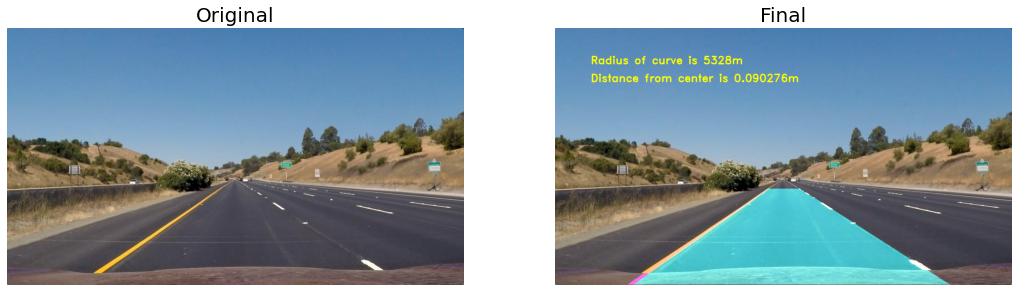

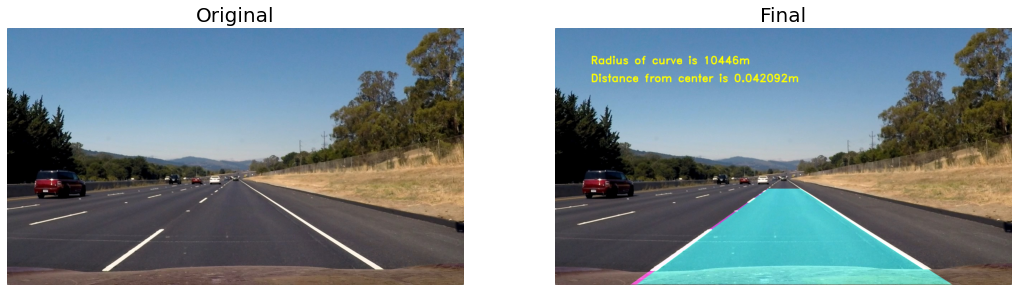

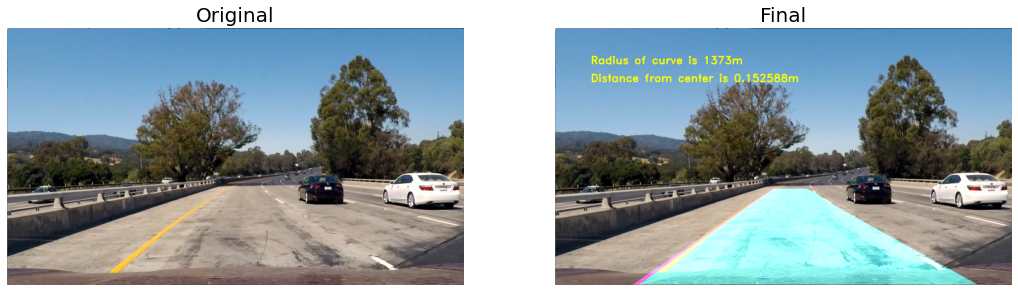

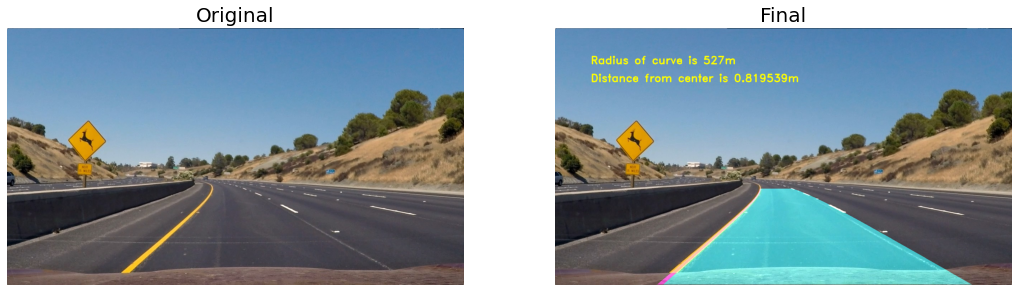

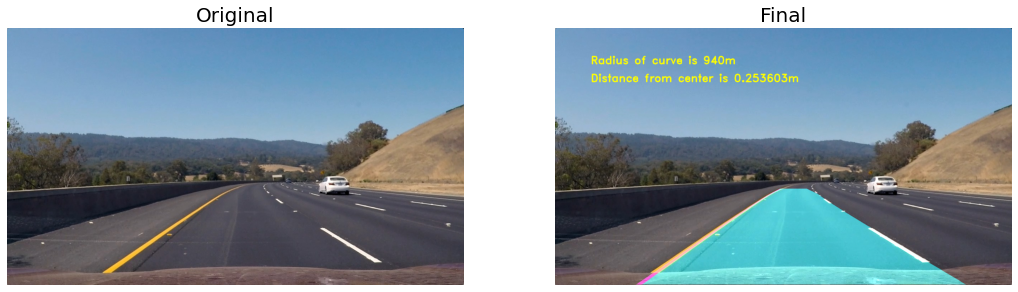

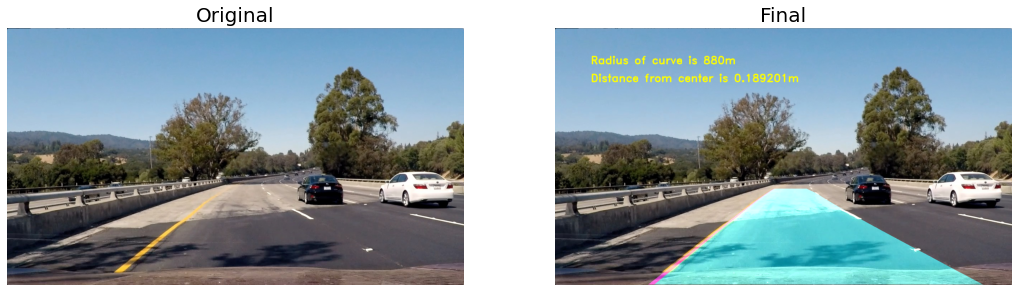

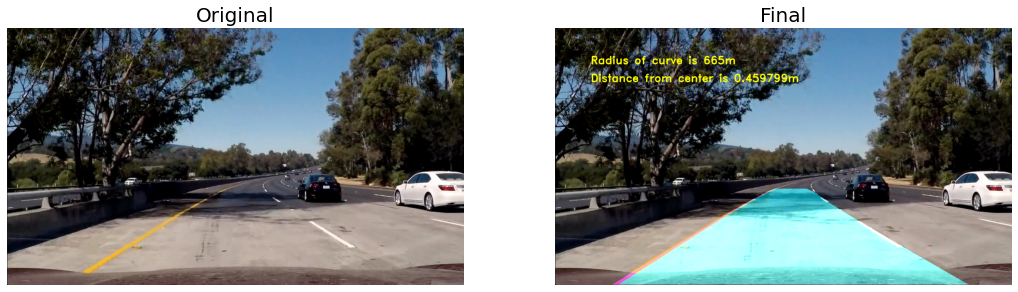

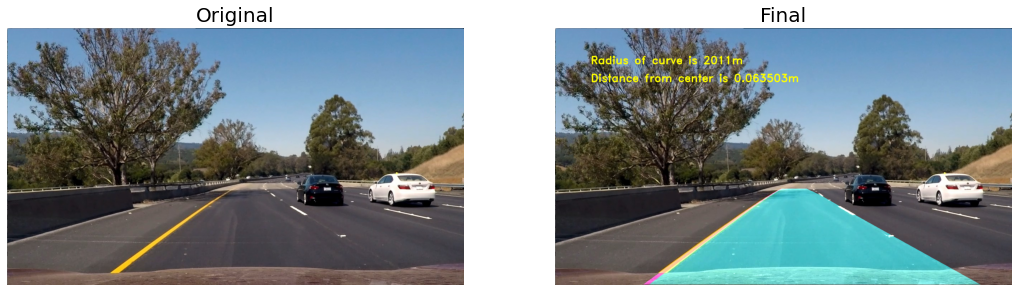

In [22]:
for image_path in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_path)
    final_image = find_lanes_advanced(image)

    _, (x1, x2) = plt.subplots(1, 2, figsize=(18, 6))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(final_image)
    x2.set_title('Final', fontsize=20)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'videos/project_video_output.mp4'
clip1 = VideoFileClip("videos/project_video.mp4").subclip(0, 5)
white_clip = clip1.fl_image(find_lanes_advanced)
%time white_clip.write_videofile(white_output, audio=False)

Video Result 

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="videos/project_video_output.mp4">
</video>b
""".format(white_output))